# 🌤️ Fetching Daily Temperature Via API

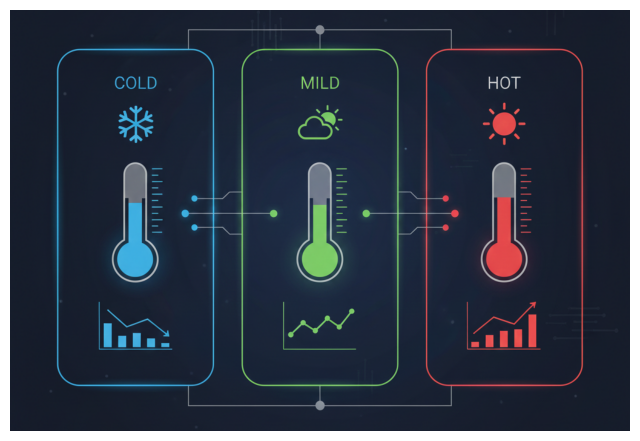

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread("../images/weather.png")

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis("off")
plt.show()

#### This notebook demonstrates how to fetch historical daily weather data from the Open-Meteo API and process it into a clean pandas DataFrame.<br> The data is prepared for storage in a Dockerized MySQL database, enabling further analysis and integration with other dataset.

In [10]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2023-01-01",
	"end_date": "2023-06-30",
	"daily": "temperature_2m_mean",
	"timezone": "America/New_York",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

daily_dataframe = pd.DataFrame(data = daily_data)
print("\nDaily data\n", daily_dataframe)

Coordinates: 40.738136291503906°N -74.04254150390625°E
Elevation: 51.0 m asl
Timezone: b'America/New_York'b'GMT-5'
Timezone difference to GMT+0: -18000s

Daily data
                          date  temperature_2m_mean
0   2023-01-01 05:00:00+00:00             8.785417
1   2023-01-02 05:00:00+00:00             7.981249
2   2023-01-03 05:00:00+00:00             9.691669
3   2023-01-04 05:00:00+00:00            13.081250
4   2023-01-05 05:00:00+00:00             9.912500
..                        ...                  ...
176 2023-06-26 05:00:00+00:00            21.787500
177 2023-06-27 05:00:00+00:00            21.758331
178 2023-06-28 05:00:00+00:00            22.835417
179 2023-06-29 05:00:00+00:00            22.354166
180 2023-06-30 05:00:00+00:00            23.039583

[181 rows x 2 columns]


### Preparing Weather DataFrame

Here we create a copy of the daily temperature DataFrame (`daily_dataframe`) to use as our **weather dataset**.  

We also convert the `date` column to **date-only format** (removing the time part)


In [11]:
weather_df = daily_dataframe.copy()
weather_df["date"] = weather_df["date"].dt.date
weather_df

,date,temperature_2m_mean
0,2023-01-01,8.785417
1,2023-01-02,7.981249
2,2023-01-03,9.691669
3,2023-01-04,13.081250
4,2023-01-05,9.912500
...,...,...
176,2023-06-26,21.787500
177,2023-06-27,21.758331
178,2023-06-28,22.835417
179,2023-06-29,22.354166


In [12]:
weather_df.rename(
    columns={"temperature_2m_mean": "avg_temp"},
    inplace=True
)

weather_df.head()

,date,avg_temp
0,2023-01-01,8.785417
1,2023-01-02,7.981249
2,2023-01-03,9.691669
3,2023-01-04,13.081250
4,2023-01-05,9.912500


#### Loading the Weather Data into Dockerized MySQL

In [13]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [14]:
load_dotenv()

DB_NAME = os.getenv("MYSQL_DATABASE")
DB_USER = os.getenv("MYSQL_USER")
DB_PASSWORD = os.getenv("MYSQL_PASSWORD")
DB_HOST = "127.0.0.1"
DB_PORT = 3306

In [15]:
engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)


In [16]:
weather_df.to_sql(
    name="weather",
    con=engine,
    if_exists="replace",
    index=False
)
print("✅ Weather data loaded from .env and written to MySQL")

✅ Weather data loaded from .env and written to MySQL


In [17]:
df_check = pd.read_sql("SELECT * FROM weather limit 5", engine)
print(df_check)

         date  avg_temp
0  2023-01-01   8.78542
1  2023-01-02   7.98125
2  2023-01-03   9.69167
3  2023-01-04  13.08130
4  2023-01-05   9.91250
